# Rebuilding the Transporation Model in Pyro


In [3]:
!pip install torch torchvision torchaudio
!pip3 install pyro-ppl

     |████████████████████████████████| 1.9MB 4.8MB/s 
     |████████████████████████████████| 634kB 7.0MB/s 


In [4]:


from statistics import mean
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)

Now that we have validated our model, let's rebuild the model with Pyro.

Usually we would take advantage of Pyro's ability to employ arbitrarily complicated parametric assumptions.  But here, we're going to simply replicate the original model to establish proof of concept.

- Age (A): Recorded as young (young) for individuals below 30 years, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.
- Sex (S): The biological sex of an individual, recorded as male (M) or female (F).
- Education (E): The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).
- Occupation (O): Employee (emp) or a self employed (self) worker.
- Residence (R): The size of the city the individual lives in, recorded as small (small) or big (big).
- Travel (T): The means of transport favored by the individual, recorded as car (car), train (train) or other (other)


![dag.png](attachment:dag.png)

In [5]:
A_alias = ['young','adult','old']
S_alias = ['M','F']
E_alias = ['high','uni']
O_alias = ['emp','self']
R_alias = ['small','big']
T_alias = ['car','train','other']

A_prob = torch.tensor([0.3,0.5,0.2])
S_prob = torch.tensor([0.6,0.4])
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]],
                     [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],
                     [[0.58,0.24,0.18], [0.7,0.21,0.09]]])

def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    S = pyro.sample("S", dist.Categorical(probs=S_prob))
    E = pyro.sample("E", dist.Categorical(probs=E_prob[S][A]))
    O = pyro.sample("O", dist.Categorical(probs=O_prob[E]))
    R = pyro.sample("R", dist.Categorical(probs=R_prob[E]))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[R][O]))
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}

print(model())

{'A': tensor(1), 'S': tensor(1), 'E': tensor(0), 'O': tensor(0), 'R': tensor(1), 'T': tensor(2)}


In [6]:
def prob_dict(alias, prob):
    dict = {}
    for i, _ in enumerate(alias):
        dict[alias[i]] = prob[i]
    return dict

In [ ]:
A_dict = prob_dict(A_alias, A_prob)
S_dict = prob_dict(S_alias, S_prob)
E_dict = prob_dict(E_alias, E_prob)
O_dict = prob_dict(O_alias, O_prob)
R_dict = prob_dict(R_alias, R_prob)
T_dict = prob_dict(T_alias, T_prob.T)

### Inference

There are two broad categories of causal inference questions, one is to predict effects from causes, referred to as forward causal inference, and the other is to predict causes from effects, referred to as reverse causal inference. Forward causal inference is straightforward to do through forward sampling, without the need of any inference algorithm. Forward sampling doesn't work for reverse causal inference, since there is no guarantee the sample generated matches the evidence we observed. An easy solution is rejection sampling, which rejects all the samples that do not match the evidence. But it can be very inefficient when the probability of the observed evidence is very small. An improvement is likelihood weighting, a special case of importance sampling, which samples unobserved variables like in forward sampling, but sets the observed variables to the same value as evidence, and weights each sample by its likelihood. An caveat of importance sampling is its accuracy depends on how close the proposal distribution is to the target distribution. In the case of Bayesian network, the proposal distribution is often the CPTs, and the target distribution is the posterior distribution we want to estimate. (For details of the theory of different sampling methods, see "Probabilistic Graphical Models" Chapter 12)

Pyro has implemented many inference algorithms including importance sampling, and we encourage you to experiment with them. Detailed understanding about how these methods work in Pyro is not a requirement. For the purpose of the homework, it's sufficient to have a high level understanding of the general idea and be able to use at least one of the inference algorithms in Pyro in your model. 

Most of the inference algorithms implemented in Pyro are approximate inference algorithms either through sampling or variational inference. Exact inference using variable elimination is NP hard. It becomes intractable when the model is large. However, most models in homeworks are fairly small. Although inference can be done manually without much efforts in small networks, inference using Pyro is required in this question.

### Forward inference

Implement forward inference using `pyro.condition`. Assuming you observed a person with a university degree. What is your prediction of this person's means of travel? Provide a histogram of the marginal distribution on the variable "T". (6 points)


In [7]:
conditioned_model = pyro.condition(model, data={'E':torch.tensor(1),'O':torch.tensor(1), 'R':torch.tensor(0)})

Text(0.5, 1.0, 'P(T | E = uni, O = emp, R = big) - Importance Sampling')

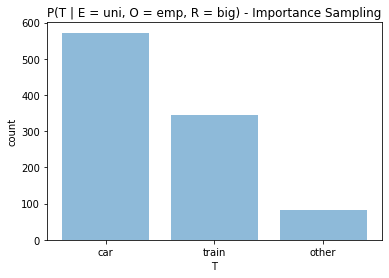

In [9]:
T_posterior = pyro.infer.Importance(conditioned_model, num_samples=5000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(1000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)

plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('count')
plt.xlabel('T')
plt.title('P(T | E = uni, O = emp, R = big) - Importance Sampling')

We can implement reverse inference using `pyro.condition` and an inference algorithm in Pyro. Assuming you observed a self-employed person who lives in a big city. What is your prediction of this person's age?  Let's generate a histogram of the marginal on the variable "A". 

In [10]:
conditioned_model = pyro.condition(model, data={'O':torch.tensor(1),'R':torch.tensor(1)})

Text(0.5, 1.0, 'P(A | O = self, R = big) - Importance Sampling')

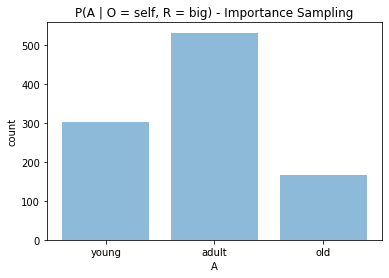

In [11]:
A_posterior = pyro.infer.Importance(conditioned_model, num_samples=5000).run()
A_marginal = EmpiricalMarginal(A_posterior,"A")
A_samples = [A_marginal().item() for _ in range(1000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts, align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('count')
plt.xlabel('A')
plt.title('P(A | O = self, R = big) - Importance Sampling')

### Intervention

Finally, we'll use the `do` operator to simulate intervention.  We'll set residence to "small".

Text(0.5, 1.0, 'P(T | do(R = small)) - Importance Sampling')

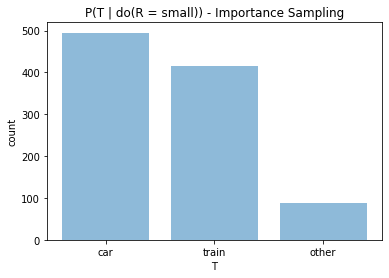

In [12]:
intervention_model = pyro.do(model, data={'R':torch.tensor(0)})

T_posterior = pyro.infer.Importance(intervention_model, num_samples=5000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(1000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)

plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('count')
plt.xlabel('T')
plt.title('P(T | do(R = small)) - Importance Sampling')